# MVP: Demo of model.

Vamos a enseñar cómo podría funcionar el modelo, también buscamos comparar la predicción con la realidad. 

## Imports

In [1]:
import dash_bootstrap_components as dbc
import geopandas as gpd
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
import requests
import warnings

from dash import Dash, html, dcc, callback, Output, Input, get_asset_url
from pandas.tseries.offsets import DateOffset
from PIL import Image
from shapely import union_all

from src.data.utils import (
    get_general_path, join_paths
)
from src.models.model_utils import (
    read_xy_set, get_model, predict
)

## Configuration

In [2]:
warnings.filterwarnings('ignore')


## Constants

In [3]:
RAW_DATA = 'data/raw/'
INTERIM_DATA = 'data/interim/'
PROCESSED_DATA = 'data/processed/'
MODEL_PATH = 'models/'

MUNICIPAL_DATA = 'municipal_data.pkl'
ALL_FEATURES_FILE = 'all_features.parquet'
TARGET_FILE = 'target_datasets.pkl'
MODEL_FILE = 'SeGuia.pkl'

MONTHS = 6
RANDOM_SEED = 69
COLUMNS =  ['mun_id', 'standard_date', 'future_date']
MEXICO_EPSG = "EPSG:6362" # https://epsg.io/6362
WGS84 = "EPSG:4326" # World Geodetic System 1984 ensemble

## Read data


In [4]:
general_path = get_general_path()
features_path = join_paths(general_path, INTERIM_DATA, ALL_FEATURES_FILE)
features = pd.read_parquet(features_path)

target_file_path = join_paths(general_path, INTERIM_DATA, TARGET_FILE)
targets = pd.read_pickle(target_file_path)

municipal_information_path = join_paths(general_path, INTERIM_DATA, MUNICIPAL_DATA)
municipal_information = pd.read_pickle(municipal_information_path)

x_oot, y_oot = read_xy_set('oot')
model = get_model('SeGuia.pkl')

## Helper functions

In [5]:
def extract_max_date_from_indexes(index_list):
    # Since indexes are ordered as cve_munid_yyyymmdd,
    # searching the max will give the maximum date. 
    max_index = oot_index.max()
    max_index_date = max_index.split('__')[1]
    date = pd.to_datetime(max_index_date, format='%Y%m%d')
    return date

## Process data

In [6]:
# Con el dataset features podremos ver el futuro, con fecha máxima: 2024-06-15 + 6 Meses.
oot_index = x_oot.index
max_oot_index_date = extract_max_date_from_indexes(oot_index)
see_the_future_set = features[features.standard_date > max_oot_index_date] 
see_the_future_set['future_date'] = see_the_future_set['standard_date'] + DateOffset(months=MONTHS)
resumed_set = see_the_future_set[COLUMNS]
future_prediction = predict(model=model, x_set=see_the_future_set.drop(COLUMNS, axis=1))
resumed_set['prediction'] = future_prediction

In [7]:
last_feature_prediction_w_target = features[features.standard_date == max_oot_index_date]
last_feature_prediction_w_target['future_date'] = last_feature_prediction_w_target['standard_date'] + DateOffset(months=MONTHS)
resumed_last_feature_prediction_w_target = last_feature_prediction_w_target[COLUMNS]
actual_prediction = predict(model=model, x_set=last_feature_prediction_w_target.drop(COLUMNS, axis=1))
resumed_last_feature_prediction_w_target['prediction'] = actual_prediction
resumed_last_feature_prediction_w_target['target'] = y_oot
resumed_last_feature_prediction_w_target['real_value'] = features[
    features.standard_date==max_oot_index_date + DateOffset(months=MONTHS)
].num_drought_index.to_list()

In [8]:
entity_list = list(municipal_information.entidad_federativa.unique())

In [9]:
future_date_list = list(resumed_set.future_date.astype('string').unique())

In [10]:
future_date_marker_dict = {i: {'label': date} for i, date in enumerate(future_date_list)}

In [55]:
from colour import Color
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap


initial_color = Color("Green")
final_color = Color("Brown")
colors = list(initial_color.range_to(Color("Brown"),1000))
colors_rgb = [c.rgb for c in colors]
colors_rgb_text = [[i/len(colors), f'rgb{tuple([round(float(rgb), 5) for rgb in c.rgb])}'] for i, c in enumerate(colors)]

cmap = LinearSegmentedColormap.from_list('Sequía', colors=colors_rgb)

In [56]:
colors_rgb_text

[[0.0, 'rgb(0.0, 0.50196, 0.0)'],
 [0.001, 'rgb(0.00111, 0.50217, 0.0001)'],
 [0.002, 'rgb(0.00221, 0.50238, 0.0002)'],
 [0.003, 'rgb(0.00332, 0.50258, 0.00031)'],
 [0.004, 'rgb(0.00443, 0.50279, 0.00041)'],
 [0.005, 'rgb(0.00554, 0.503, 0.00051)'],
 [0.006, 'rgb(0.00665, 0.50321, 0.00061)'],
 [0.007, 'rgb(0.00776, 0.50341, 0.00072)'],
 [0.008, 'rgb(0.00887, 0.50362, 0.00082)'],
 [0.009, 'rgb(0.00998, 0.50383, 0.00092)'],
 [0.01, 'rgb(0.0111, 0.50404, 0.00103)'],
 [0.011, 'rgb(0.01221, 0.50424, 0.00113)'],
 [0.012, 'rgb(0.01332, 0.50445, 0.00123)'],
 [0.013, 'rgb(0.01444, 0.50466, 0.00134)'],
 [0.014, 'rgb(0.01555, 0.50486, 0.00144)'],
 [0.015, 'rgb(0.01666, 0.50507, 0.00154)'],
 [0.016, 'rgb(0.01778, 0.50528, 0.00165)'],
 [0.017, 'rgb(0.0189, 0.50548, 0.00175)'],
 [0.018, 'rgb(0.02001, 0.50569, 0.00186)'],
 [0.019, 'rgb(0.02113, 0.50589, 0.00196)'],
 [0.02, 'rgb(0.02225, 0.5061, 0.00206)'],
 [0.021, 'rgb(0.02336, 0.5063, 0.00217)'],
 [0.022, 'rgb(0.02448, 0.50651, 0.00227)'],
 [0.023,

<Axes: title={'center': 'Valor real de la fecha 2024-06-15'}>

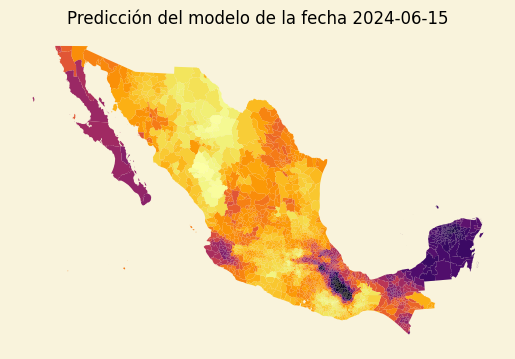

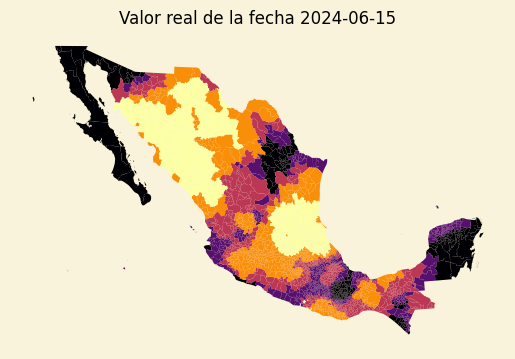

In [68]:
def plot_value_map(column_to_plot, title):
    rlfpwt = resumed_last_feature_prediction_w_target.set_index('mun_id')
    rlfpwt = rlfpwt.merge(municipal_information, left_index=True, right_index=True)
    rlfpwt = gpd.GeoDataFrame(rlfpwt)
    color_hex = '#f9f3dc'
    #color_hex = '#d9e3f1'

    fig, ax = plt.subplots(facecolor=color_hex)
    rlfpwt.plot(column=column_to_plot, cmap='inferno', ax=ax)
    future_date = rlfpwt.future_date.unique()[0].strftime('%Y-%m-%d')
    title = f'{title} de la fecha {future_date}'
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    ax.set_facecolor(color_hex)
    #ax.set_facecolor('#d9e3f1')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.savefig(f'../reports/figures/{column_to_plot}.png')
    return ax 

plot_value_map('prediction', 'Predicción del modelo')
plot_value_map('real_value','Valor real')

In [ ]:
plot

In [20]:
# @callback(
#     Output('model-real_value-map', 'figure')
# )
def plot_realvalue_map():
    rlfpwt = resumed_last_feature_prediction_w_target.set_index('mun_id')
    rlfpwt = rlfpwt.merge(municipal_information, left_index=True, right_index=True)
    rlfpwt = gpd.GeoDataFrame(rlfpwt)
    gdf = rlfpwt[['geometry', 'nombre_municipio']].set_crs(MEXICO_EPSG).to_crs(WGS84)
    dff = rlfpwt[['nombre_municipio', 'prediction']]
    fig = px.choropleth(
        dff,
        geojson=gdf.__geo_interface__,
        color="real_value",
        locations="nombre_municipio",
        featureidkey="properties.nombre_municipio",
        projection="mercator",
        color_continuous_scale="deep"
    )
    fig.update_geos(fitbounds="locations", visible=True)
    fig.update_layout(height=250,width=250)
    return fig

# @callback(
#     Output('model-prediction-map', 'figure')
# )
def plot_prediction_map():
    rlfpwt = resumed_last_feature_prediction_w_target.set_index('mun_id')
    rlfpwt = rlfpwt.merge(municipal_information, left_index=True, right_index=True)
    rlfpwt = gpd.GeoDataFrame(rlfpwt)
    gdf = rlfpwt[['geometry', 'nombre_municipio']].set_crs(MEXICO_EPSG).to_crs(WGS84)
    dff = rlfpwt[['nombre_municipio', 'prediction']]
    fig = px.choropleth(
        dff,
        geojson=gdf.__geo_interface__,
        color="prediction",
        locations="nombre_municipio",
        featureidkey="properties.nombre_municipio",
        projection="mercator",
        color_continuous_scale="deep"
    )
    fig.update_geos(fitbounds="locations", visible=True)
    fig.update_layout(height=250,width=250)
    return fig

    



@callback(
    Output('state-map', 'figure'),
    Input('date-filter-for-prediction', 'value'),
    Input('entity-dropdown-for-prediction', 'value'),

)
def plot_entity_municipalities_future_drought(selected_future_date_idx, selected_entity):
    selected_future_date = future_date_list[selected_future_date_idx]
    
    resumed_set_date = resumed_set[resumed_set['future_date'] == selected_future_date].set_index('mun_id')
    resumed_set_date_info = resumed_set_date.merge(municipal_information, left_index=True, right_index=True)
    resumed_set_date_info_entity = gpd.GeoDataFrame(resumed_set_date_info[resumed_set_date_info.entidad_federativa==selected_entity])
    gdf = resumed_set_date_info_entity[
        ['geometry', 'nombre_municipio']
    ].set_crs(MEXICO_EPSG).to_crs(WGS84)
    dff = resumed_set_date_info_entity[
        ['nombre_municipio', 'prediction']
    ]

    fig = px.choropleth(
        dff,
        geojson=gdf.__geo_interface__,
        color="prediction",
        locations="nombre_municipio",
        featureidkey="properties.nombre_municipio",
        projection="mercator",
        color_continuous_scale="deep"
    )
    fig.update_geos(fitbounds="locations", visible=True)
    fig.update_layout(height=1000,width=1000, clickmode='event+select')
    return fig

    # TODO: set a max and min thresholds
    # Set color of background for appreciation
    # Set color pallete
    # Remove indexes. 
    # Use plotly to plot the map. 
    # Hover over municipalities to get additional information

In [21]:
# data input and resources
seguia_logo_img = Image.open("../references/branding/Logo seguia.png")

In [23]:
theme = dbc.themes.MORPH

descr_seguia = 'SeGuía es un modelo de inteligencia artificial diseñado para predecir la presencia de sequías. Utiliza datos históricos del Monitor de Sequía en México (MSM), junto con información climatológica de la Nasa, geológica y demográfica de diversas fuentes, para realizar predicciones anticipadas.'
usual_padding = '5px 20px 20px 20px'
extreme_padding = '3px 100px 3px 100px'
descr_demo_lista = 'Use la lista desplegable para cambiar el estado.'
descr_demo_slider = 'Para cambiar la fecha de la predicción, modifique el valor de la barra la fecha deseada.'
app = Dash(
    __name__,
    external_stylesheets=[theme]
)

app.layout = html.Div([
    # html.H1(children='SeGuía', style={'textAlign':'center'}),
    html.Div([html.Img(src=seguia_logo_img)], style={'textAlign': 'center', "fontSize": "1.5rem"}),
    html.P(children=descr_seguia, style={'padding': usual_padding, 'textAlign': 'center',  "fontSize": "1.5rem"}),
    html.Div([dcc.Dropdown(entity_list, 'Jalisco', id='entity-dropdown-for-prediction',),
              html.P(children=descr_demo_lista),],
             style={'width': '100%', 'textAlign': 'center', 'padding': usual_padding, "fontSize": "1.5rem"},
    ),
    html.Div([dcc.Graph(id='state-map', style={'width': '100%', 'height': '800', 'textAlign': 'center','padding': extreme_padding})], style={'textAlign': 'center'}),
    html.Div(
        [
            #html.Div([dbc.Row([dbc.Col(dcc.Graph(id='state-map')),], justify='center'),], style={"justify" : "center"}),
            html.H3(children='Selecciona una fecha:'),
            dcc.Slider(0, len(future_date_list), 2, value=0, marks=future_date_marker_dict, id='date-filter-for-prediction',),
        ],
        style={'width': '100%','textAlign': 'center', 'padding': usual_padding,},
    ),
    html.P(children=descr_demo_slider, style={"fontSize": "1.5rem"}),
    html.H2(children='¿Por qué confiar en SeGuía?', style={"fontSize": "1.5rem"}),
    html.Div([
        html.Div([
            html.H3(children='Predicción '),

        ], style={'width': '48%', 'display': 'inline-block',
                  'textAlign': 'center'}),
        html.Div([
            html.H3(children='Realidad '),
        ], style={'width': '48%', 'display': 'inline-block',
                  'textAlign': 'center'})
    ]),
    html.Div([
        html.Div([
            html.Div([html.Img(
                src=Image.open('reports/figures/prediction.png'))],
                     style={'textAlign': 'center'}),

        ], style={'width': '48%', 'display': 'inline-block',
                  'float': 'left', }),
        html.Div([
            html.Div([html.Img(
                src=Image.open('reports/figures/real_value.png'))],
                     style={'textAlign': 'center'}),
        ], style={'width': '48%', 'display': 'inline-block',
                  'float': 'right', })
    ]),
])
if __name__ == '__main__':
    app.run()